# Some Tests for a Wikipedia Retriever

Important note: While there may be use cases for grading articles with an LLM before retrieving relevant passages from them, in this case, it is worth neither the cimputational overhead nor the additional error rates caused by unreliable LLMs. It is simply faster and more reliable to retrieve a larger number of articles from wikipedia (set with `articles_considered`), put them all into a vector store to split them into context window friendly chunks, and have a capable retriever pick out the relevant passages.

In [1]:
# Settings

verbose = True # additional output for testing and troubleshooting

articles_considered = 10 # number of wikipedia articles retrieved. The reasoning_model will pick relevant articles from these. Higher numbers add overhead!

grade_articles = False # whether or not the reasoning_model model should grade the articles for relevance before downloading all articles returned by the wikipedia search

grading_fallback = True # should the model resort to scraping all articles if the grading did not return andy articles?

structured_output = True # force the reasoning_model grading articles to return structured output for reliability. Some models may not support this

docs_returned = 6 # number of wikipedia article snippets returned by the retriever. Make sure this fits the context window of the model

retriever_type = "mmr" # "similarity"  or "mmr"

embedding_model = "nomic-embed-text" # very good embedding model for retrieval tasks

# textgen model. generates answers to questions, with retrieved documents as context
textgen_model = "llama3.2"
# textgen_model = "phi4", # phi4 is a rather powerful model, but requires more gpu compute (that is, it will be slower than llama3.2 if not enough gpu memory is available)

# reasoning model. handles deciding whether or not to query the retriever
# reasoning_model = "nemotron-mini" # nvidia's nemotron-mini does not do a good job a judging the relevance of articles
# reasoning_model = "phi4" # phi4 fails the grading task as well
reasoning_model = "llama3.2" # fast, but not very good at reasoning tasks. however, somewhat okay at grading the articles
# reasoning_model = "qwq" # qwq is a rather powerful experimental reasoning model. However, as it is rather large (20b), it either requires a fair bit of GPU memory or will be very slow 

In [2]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings

textgen_llm = ChatOllama(
    model = textgen_model,
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOllama(
    model = reasoning_model, 
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )

embeddings = OllamaEmbeddings(model = embedding_model)

 ## pass settings for retriever (adjust as needed)
if retriever_type == "mmr":
    search_type="mmr" # MMR (Maximal Marginal Relevance) aims to diversify search results. the amount of diversification is set via the lambda_mult parameter
    search_kwargs={"k": docs_returned, # make sure the number of documents passed (k) fits into the context window
                    "fetch_k": docs_returned * 5, # could be adjusted, potentially run tests
                    "lambda_mult": 0.8} # amount of diversification, with 0 being maximum diversity
                   
if retriever_type == "similarity":
    search_type="similarity" # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": docs_returned} # make sure the number of documents passed (k) fits into the context window

In [3]:
system_prompt = (
  "You are a helpful assistant for finding relevant text passages on Wikipedia."
   "Use the following pieces of retrieved context to answer the question."
   "Each piece of content starts with the indicator 'Title'. Always provide this in your answer when using one of the retrieved passages."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)

# note that the generated answer is highly dependent on the system prompt, e.g. adding \n between the lines changes the output
#   (potentially depending on the model)

In [4]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Initialize Wikipedia tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [5]:
wikipedia.run("Public Sphere")

# This returns the results of a query, with only providing the summary for each of the pages retrieved (here: 3 pages - 'Public Sphere', 'The Strctural Transformation of the Public Sphere', and 'Public Domain') 

'Page: Public sphere\nSummary: The public sphere (German: Öffentlichkeit) is an area in social life where individuals can come together to freely discuss and identify societal problems, and through that discussion influence political action. A "Public" is "of or concerning the people as a whole." Such a discussion is called public debate and is defined as the expression of views on matters that are of concern to the public—often, but not always, with opposing or diverging views being expressed by participants in the discussion. Public debate takes place mostly through the mass media, but also at meetings or through social media, academic publications and government policy documents.\nThe term was originally coined by German philosopher Jürgen Habermas who defined the public sphere as "made up of private people gathered together as a public and articulating the needs of society with the state". Communication scholar Gerard A. Hauser defines it as "a discursive space in which individuals

In [6]:
from langchain_community.retrievers import WikipediaRetriever

wiki_retriever = WikipediaRetriever(doc_content_chars_max = 1000000) # this sets the length of the articles. summaries are always returned in full

In [7]:
wiki_retriever.invoke("Public Sphere")

# This returns different results than the WikipediaQueryRun
# Additionally, the summary is provided as metadata, and the full text is provided but capped (`doc_content_chars_max` argument?)

[Document(metadata={'title': 'Public sphere', 'summary': 'The public sphere (German: Öffentlichkeit) is an area in social life where individuals can come together to freely discuss and identify societal problems, and through that discussion influence political action. A "Public" is "of or concerning the people as a whole." Such a discussion is called public debate and is defined as the expression of views on matters that are of concern to the public—often, but not always, with opposing or diverging views being expressed by participants in the discussion. Public debate takes place mostly through the mass media, but also at meetings or through social media, academic publications and government policy documents.\nThe term was originally coined by German philosopher Jürgen Habermas who defined the public sphere as "made up of private people gathered together as a public and articulating the needs of society with the state". Communication scholar Gerard A. Hauser defines it as "a discursive

In [8]:
wiki_retriever.invoke("What is the Public Sphere?")

# note that the retriever handles questions rather well

[Document(metadata={'title': 'Public sphere', 'summary': 'The public sphere (German: Öffentlichkeit) is an area in social life where individuals can come together to freely discuss and identify societal problems, and through that discussion influence political action. A "Public" is "of or concerning the people as a whole." Such a discussion is called public debate and is defined as the expression of views on matters that are of concern to the public—often, but not always, with opposing or diverging views being expressed by participants in the discussion. Public debate takes place mostly through the mass media, but also at meetings or through social media, academic publications and government policy documents.\nThe term was originally coined by German philosopher Jürgen Habermas who defined the public sphere as "made up of private people gathered together as a public and articulating the needs of society with the state". Communication scholar Gerard A. Hauser defines it as "a discursive

In [9]:

from langchain_core.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.retrievers import WikipediaRetriever
from pydantic import BaseModel, Field
from typing import List

# Note: results can differ depending on model and prompt. It is importan the model reliably outputs only the title
grading_prompt = PromptTemplate.from_template("""
You are a helpful assistant, deciding which of these wikipedia articles is relevant to the user's question, based on their provided summaries.
Only ever respond with the relevant article's 'Title', as provided in the prompt, and nothing else. If more than one article is relevant, separate the titles with a semicolon.

Question: {question}

Available articles: 
                                              
{articles}
""")

# using a LLM with structured output helps immensely with reliable grader output. Optional as support for this form is model-dependant
if structured_output:

    class relevant_articles(BaseModel):
        """Articles relevant to the question"""
        titles: List[str]



article_retriever = WikipediaRetriever(doc_content_chars_max=1000000, top_k_results=1)

In [10]:
from langgraph.graph import MessagesState
from langchain_core.tools import StructuredTool
import re

def wiki_retrieve(query: str):

    """Search and return relevant text passages from Wikipedia that can be used to answer the question."""

    if verbose: print(f"Query: {query}")

    if verbose: print("Searching Wikipedia...")
    # get article summaries and titles from wikipedia

    if grade_articles:

        summary_retriever = WikipediaRetriever(doc_content_chars_max=0, top_k_results=articles_considered)

        summaries = summary_retriever.invoke(query)

        article_titles = [doc.metadata.get("title", "") for doc in summaries]

        if verbose: print(f"Articles found: {article_titles}")

        articles = "\n\n".join(
            (f"Title: {doc.metadata["title"]}\n" f"Summary: {doc.metadata["summary"]}")
            for doc in summaries
            )

        # grade the summaries, identify relevant articles
        prompt = grading_prompt.invoke({"question": query, "articles": articles})

        if structured_output:
            structured_llm = reasoning_llm.with_structured_output(relevant_articles)
            relevant = structured_llm.invoke(prompt)

            if relevant is None: # check if the model returned invalid output
                fail_reason = "The model did not return structured output."
                titles = False
            else:
                titles = relevant.titles
                fail_reason = "No articles considered relevant."

        if structured_output is False or titles is False: # fall back option. less reliable

            if verbose and structured_output: print("Structured model output failed. Using free form fallback option.")
            relevant = reasoning_llm.invoke(prompt)

            if len(relevant.content) > (len(", ".join(article_titles)) + 5*len(article_titles)): # check if the model returned invalid output
                fail_reason = "The model did not return structured output."
                # (we give a margin of 5 extra characters per title just in case, but if the output is longer than that, it failed)
                titles = False
            else:
                titles = re.split(r';\s*', relevant.content)
                fail_reason = "No articles considered relevant."

        if titles is not False: 
            if verbose: print(f"Relevant articles: {titles}")

            # get the full articles from wikipedia
            if verbose: print("Getting full articles...")

            article_retriever = WikipediaRetriever(doc_content_chars_max=1000000, top_k_results=1) # only get one article per title (that is, the exact article)

            full_articles = [doc for title in titles for doc in article_retriever.invoke(title)] # double loop removes one level of hierarchy present otherwise


        if titles is False:
            if grading_fallback: 
                if verbose: print("Grading failed. Falling back to scraping all articles.") 
            else: # if no fallback is desired, we give dummy output and finish here
                if verbose: print(f"No articles returned. Reason: {fail_reason}")
                serialized = "No relevant articles found."
                retrieved_docs = []
                return serialized, retrieved_docs


    if not grade_articles or grading_fallback: # we can fall back to this if the grading failed

        article_retriever = WikipediaRetriever(doc_content_chars_max=1000000, top_k_results=articles_considered) # pass the number of full articles to retrieve from the settings (get more than 1 in this case)
        full_articles = article_retriever.invoke(query)

        article_titles = [doc.metadata.get("title", "") for doc in full_articles]
        if verbose: print(f"Articles found: {article_titles}")

    # make a vector store with snippets of the articles to retrieve relevant passages
    text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,  # chunk size (characters)
                chunk_overlap=200,  # chunk overlap (characters)
                add_start_index=True,  # track index in original document
    )
                
    wiki_shorts = text_splitter.split_documents(full_articles)
    # an InMemoryVectorStore is sufficient to temporariliy store the embeddings
    vector_store = InMemoryVectorStore(embedding=embeddings)
    vector_store.add_documents(wiki_shorts)

    if verbose: print("Retrieving relevant passages from the articles...")
    wiki_store = vector_store.as_retriever(
        search_type=search_type, 
        search_kwargs=search_kwargs, 
        )

    retrieved_docs = wiki_store.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata["title"]}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )


    return serialized, retrieved_docs
    



In [11]:
# turn the function into a tool

description = "Search and return relevant text passages from Wikipedia that can be used to answer the question."

if reasoning_llm.__getattribute__("model") == "nemotron-mini":
    # the additional specifications on the output format are (currently) necessary for the nemotron ollama model, see: https://github.com/ollama/ollama/issues/8287
    description += """
    For each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:
    <tool_call>
    {"name": <function-name>, "arguments": <args-json-object>}
    </tool_call>
    """
    
wikipedia_tool = StructuredTool.from_function(
    func=wiki_retrieve,
    name = "WikpiediaRetriever",
    description = description,
    return_direct=True,
)


In [12]:
# Build an agent to query the Wikipedia tool
# This is mostly helpful for generating a query from more complex conversations

def query_wiki(state: MessagesState):
    """Generate tool call to retrieve Wikipedia articles."""
    llm_with_tools = reasoning_llm.bind_tools([wikipedia_tool])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


In [14]:
# build the router

from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState
import json

# router instructions. behavior of the router is highly sensitive to the prompt!
router_instructions = """
You are an expert at deciding whether or not to query a search on Wikipedia or respond to the user directly.
Only respond directly to generic user input, such as greetings. For more specific thematic questions, query a search on Wikipedia.
Return JSON with single key, datasource, that is 'wiki' or 'respond' depending on the question."""

# turn the reasoning model into a json model for more structured output (more robust than text output)
reasoning_llm_json = ChatOllama(model=reasoning_model, 
                            temperature=0, 
                            format="json")

def route_question(state: MessagesState):
    """
    Route question to retriever or respond directly.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    # format messages & make prompt

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(router_instructions)] + conversation_messages

    if verbose: print("---ROUTE QUESTION---")
    route_question = reasoning_llm_json.invoke(prompt)
    source = json.loads(route_question.content)["datasource"]
    if source == "wiki":
        if verbose: print("---ROUTE QUESTION TO RETRIEVER---")
        decision = "query_wiki"
    elif source == "respond":
        if verbose: print("---RESPOND DIRECTLY---")
        decision = "respond"
    return decision

In [13]:
from langchain_core.messages import SystemMessage

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

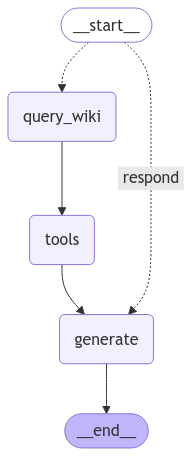

In [16]:
# set up the graph, including a conditional pass on the tools-based generation nodes

from langgraph.graph import END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph # we're using the MessageState to represent the different parts of our agent in a conversation
from langgraph.prebuilt import ToolNode

tools = ToolNode([wikipedia_tool]) # define the tools as a node

tool_graph_builder = StateGraph(MessagesState)

tool_graph_builder.set_conditional_entry_point(
    route_question,
    {
        "query_wiki": "query_wiki",
        "respond": "generate",
    }
)

tool_graph_builder.add_node(generate)
tool_graph_builder.add_node(query_wiki)
tool_graph_builder.add_node(tools)

tool_graph_builder.add_edge("query_wiki", "tools")
tool_graph_builder.add_edge("tools", "generate")
tool_graph_builder.add_edge("generate", END)

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
tool_graph = tool_graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test_thread"}}

display(Image(tool_graph.get_graph().draw_mermaid_png())) # show our graph architecture

In [18]:
input_message = "Hey, how's it going?" 

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

---ROUTE QUESTION---
---RESPOND DIRECTLY---
================================ Human Message =================================

Hey, how's it going?
================================== Ai Message ==================================

I'm doing well, thanks for asking! I'm here to help with any questions or topics you'd like to discuss. What's on your mind? Do you have a specific question about Wikipedia or would you like me to retrieve some context for you?


In [19]:
input_message = "What is the public sphere?" 

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

---ROUTE QUESTION---
---ROUTE QUESTION TO RETRIEVER---
================================ Human Message =================================

What is the public sphere?
================================== Ai Message ==================================
Tool Calls:
  WikpiediaRetriever (ebbbb9f3-046d-47a9-938f-757059728511)
 Call ID: ebbbb9f3-046d-47a9-938f-757059728511
  Args:
    query: public sphere
Query: public sphere
Searching Wikipedia...
Articles found: ['Public sphere', 'The Structural Transformation of the Public Sphere', 'Public domain', 'Public sphere pedagogy', 'European public sphere', 'Private sphere', 'Separate spheres', 'Public', 'Intellectual', 'Age of Enlightenment']
Retrieving relevant passages from the articles...
================================= Tool Message =================================
Name: WikpiediaRetriever

('Source: The Structural Transformation of the Public Sphere\nContent: == The public sphere ==\n\nSource: Public sphere pedagogy\nContent: === Public sphere 

In [20]:
input_message = "Does Rawls have anything to say about that?" 

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

---ROUTE QUESTION---
---ROUTE QUESTION TO RETRIEVER---
================================ Human Message =================================

Does Rawls have anything to say about that?
================================== Ai Message ==================================
Tool Calls:
  WikpiediaRetriever (68243e3f-6208-423f-87d3-3bf7a7dc46f2)
 Call ID: 68243e3f-6208-423f-87d3-3bf7a7dc46f2
  Args:
    query: John Rawls and public sphere
Query: John Rawls and public sphere
Searching Wikipedia...
Articles found: ['Public reason', 'Jürgen Habermas', 'Public interest', 'Secularism', 'The Public and Its Problems', 'Political ethics', 'United States Air Force Symbol', 'Social Justice in the Liberal State', 'Neoclassical liberalism', 'Anarchy, State, and Utopia']
Retrieving relevant passages from the articles...
================================= Tool Message =================================
Name: WikpiediaRetriever

('Source: Jürgen Habermas\nContent: === The public sphere ===\n\nSource: Jürgen Habermas

Note that the model tends to hallucinate / use its stock knowledge when the retriever does not return any relevant documents!

to do:
- implement the wikipedia tool into a larger graph with literature retriever and zotero retriever